# Random walk kernels experiments

### Imports

In [1221]:
#GraKel patch
import ssl
from urllib.request import urlopen
from shutil import copyfileobj
from grakel.datasets import base as gk_direct

def _download_zip_fixed(url, output_name):
    ctx = ssl.create_default_context(ssl.Purpose.SERVER_AUTH)
    filename = output_name + ".zip"
    data_url = urlopen(url, context=ctx)
    try:
        with open(filename, "w+b") as f:
            copyfileobj(data_url, f)
    finally:
        data_url.close()

gk_direct._download_zip = _download_zip_fixed

for name in ["MUTAG", "PTC_MR", "PROTEINS", "ENZYMES"]:
    gk_direct.dataset_metadata[name]["link"] = f"{"https://www.chrsmrrs.com/graphkerneldatasets/"}{name}.zip"

In [1195]:
from sage.all import *
import networkx as nx
from grakel.datasets import fetch_dataset
import numpy as np
from typing import Optional, List
import matplotlib.pyplot as plt
import random
import time

### Downloading Datasets

In [1196]:
mutag = fetch_dataset("MUTAG", verbose=False, as_graphs=True)
mutag_graphs, y = mutag.data, mutag.target
print(len(mutag_graphs))

188


### Random Graph Generator

In [1197]:
base_label = 1

def nx_to_sage_graph(g) -> Graph:
    if not isinstance(g, (nx.Graph, nx.DiGraph, nx.MultiGraph, nx.MultiDiGraph)):
        raise TypeError("Not nx graph")
    sg = Graph()
    sg.add_vertices(list(g.nodes()))
    sg.add_edges([(u, v, base_label) for (u, v) in g.edges()])
    return sg
    

def graph_gen(kind: str, n: int, seed: Optional[int] = np.random.SeedSequence().entropy) -> Graph:
    """
    er for Erdos-Renyi;
    ba for Barabasi-Albert;
    ws for Watts-Strogtz (small-world);
    sbm for Stochastic Block Model
    """
    
    if kind == "er":
        #Erdos-Renyi
        #p = 2.0/n gives us a moderately sparse graph:
        #E[deg] = (n - 1) * p = 2
        return nx_to_sage_graph(nx.erdos_renyi_graph(n=n, p=float(2.0/n), seed=seed))
    
    if kind == "ba":
        #Barabasi-Albert (preferential attachment)
        # Each new node connects to m = max(1, n // 20) existing nodes.
        # This yields a scale-free graph with hubs.
        return nx_to_sage_graph(nx.barabasi_albert_graph(n=n, m=max(1, n // 20), seed=seed))
    
    if kind == "ws":
        #Watts-Strogtz (small-world)
        # Start with a ring where each node connects to k neighbors, then rewire edges with p = 0.1.
        # This keeps high clustering while creating short average paths.
        k = int(max(2, (n // 10) | 1))
        p = float(0.1)
        return nx_to_sage_graph(nx.watts_strogatz_graph(n=n, k=k, p=p, seed=seed))

    if kind == "sbm":
        # Stochastic Block Model with 2 groups.
        # Connect nodes within the same group with p_in = 0.15,
        # and across groups with p_out = 0.02 (weaker connections).
        sizes = [n//2, n - n//2]
        p_in, p_out = float(0.15), float(0.02)
        P = [
            [p_in,  p_out],
            [p_out, p_in]
        ]
        return nx_to_sage_graph(nx.stochastic_block_model(sizes, P, seed=seed))
    
    raise ValueError(f"unknown kind: {kind}")


### Visualising graph and adjacency matrix

In [1198]:
def gk_to_sage_graph(gk_graph, undirected=True) -> Graph:
    A = gk_graph.get_adjacency_matrix()
    labels = gk_graph.get_labels(label_type="edge", purpose="adjacency", return_none=True)
    n = A.shape[0]
    edges = []

    for i in range(n):
        for j in range(i + 1, n):
            if A[i, j] != 0:
                label = None if labels is None else labels.get((i, j), labels.get((j, i)))
                if label is None:
                    edges.append((i, j, base_label))
                else:
                    edges.append((i, j, label))

    sg = Graph(edges, loops=False, multiedges=False)
    if not undirected:
        sg = sg.to_directed()
    return sg

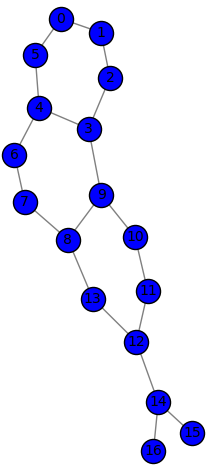

In [1199]:
sg_mutag = gk_to_sage_graph(mutag_graphs[int(0)])
sg_mutag.plot(vertex_color="blue", edge_color="gray", vertex_size=300, layout="spring").show()

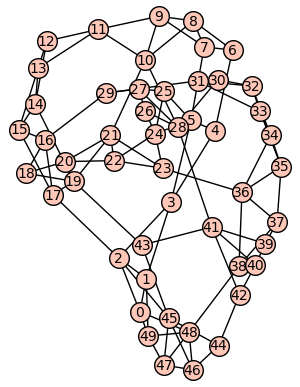

In [1200]:
sg_ws = graph_gen("ws", int(50))
sg_ws.show()

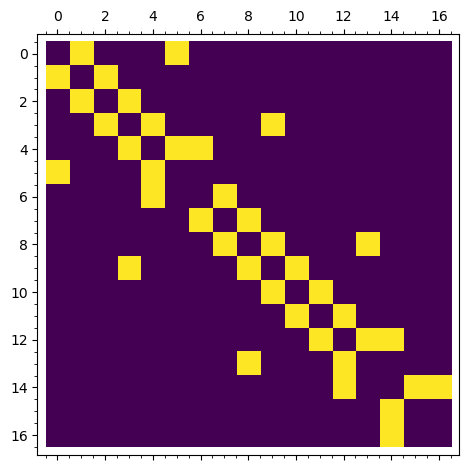

In [1201]:
A_mutag = sg_mutag.adjacency_matrix()
matrix_plot(A_mutag, cmap='viridis')

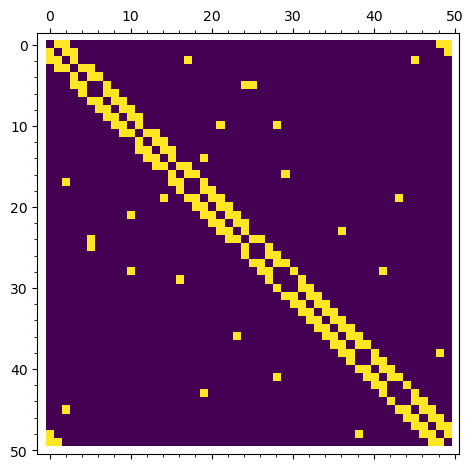

In [1202]:
A_ws = sg_ws.adjacency_matrix()
matrix_plot(A_ws, cmap='viridis')

## Random Walk Kernels

We will implement Random-Walk Kernels computation based on [Fast Computation of Graph Kernels](https://proceedings.neurips.cc/paper_files/paper/2006/file/e37b08dd3015330dcbb5d6663667b8b8-Paper.pdf) by S.V.N. Vishwanathan, Karsten M. Borgwardt, Nicol N. Schraudolph

By defenitions $k(G, G') = q_x^T(I - \lambda * W_x)^{-1}p_x$, where $W_x = A \bigotimes A'$ (A - normalized adjacency matrix), $q_x = q \bigotimes q', p_x = p \bigotimes p'$

In [1203]:
def labeled_norm_adj_mats(g: Graph, sparse=True):
    n = g.num_verts()
    deg = [g.degree(v) for v in range(n)]
    inv_deg = [RDF(0) if d == 0 else RDF(1)/RDF(d) for d in deg]
    
    A = {}
    for u, v, label in g.edge_iterator(labels=True):
        label = base_label if label is None else label
        if label not in A:
            A[label] = matrix(RDF, n, n, sparse=sparse)
        A[label][u, v] = inv_deg[v]
        A[label][v, u] = inv_deg[u]
        
    return A

In [1204]:
def rw_kernel_labeled(g1: Graph, g2: Graph, lmbd: float, p1: vector, p2: vector, q1: vector, q2:vector, R=RDF, sparse=True):
    n1, n2 = g1.num_verts(), g2.num_verts()
    n = n1 * n2
    p = vector(R, p1.tensor_product(p2).list())
    q = vector(R, q1.tensor_product(q2).list())

    A1 = labeled_norm_adj_mats(g1, sparse=sparse)
    A2 = labeled_norm_adj_mats(g2, sparse=sparse)
    
    W = zero_matrix(R, n, n, sparse=sparse)
    for label in set(A1) & set(A2):
        W += A1[label].tensor_product(A2[label])

    M = identity_matrix(R, n, sparse=sparse) - R(lmbd) * W
    x = M.solve_right(p) # (I - lmbd * W) x = p
    return float(q.dot_product(x)) # q^T * x

0.004836194522770777
0.0048361945227707774
0.006299757475677592


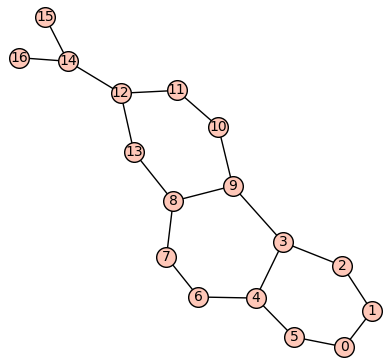

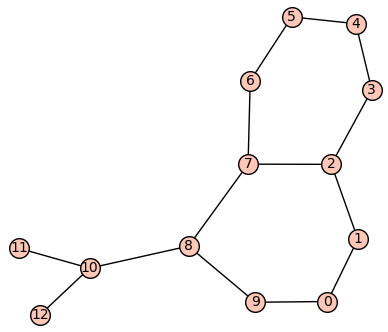

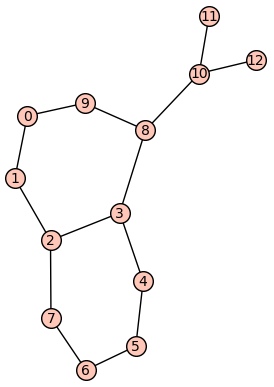

In [1205]:
g1 = gk_to_sage_graph(mutag_graphs[int(0)])
g2 = gk_to_sage_graph(mutag_graphs[int(1)])
g3 = gk_to_sage_graph(mutag_graphs[int(2)])

n1 = int(g1.num_verts())
n2 = int(g2.num_verts())
n3 = int(g3.num_verts())

p1 = vector(RDF, [1 / n1] * n1)
q1 = vector(RDF, [1 / n1] * n1)

p2 = vector(RDF, [1 / n2] * n2)
q2 = vector(RDF, [1 / n2] * n2)

p3 = vector(RDF, [1 / n3] * n3)
q3 = vector(RDF, [1 / n3] * n3)

lmbd = float(0.1)

k12 = rw_kernel_labeled(g1, g2, lmbd, p1, p2, q1, q2)
print(k12)

k13 = rw_kernel_labeled(g1, g3, lmbd, p1, p3, q1, q3)
print(k13)

k23 = rw_kernel_labeled(g3, g2, lmbd, p3, p2, q3, q2)
print(k23)

g1.show()
g2.show()
g3.show()

### Efficient Computations

#### Sylvester Equation Methods

In [1206]:
def generalized_sylvester_equation_solver(Ss: List[matrix], Ts: List[matrix], X0: matrix, lmbd: float, R=RDF, max_iter=100, eps=1e-30) -> matrix:
    """
    solve genralized sylvester equation: X = sum_i=1^d S_i X T_i 
    """
    X = X0
    for i in range(max_iter):
        SXTs = sum(S * X * T for S, T in zip(Ss, Ts))
        X_new = lmbd * SXTs + X0
        if (X_new - X).norm() <= eps:
            return X_new
        X = X_new
    return X

def rw_kernel_sylvester_equation(g1: Graph, g2: Graph, lmbd: float, p1: vector, p2: vector, q1: vector, q2: vector, sparse=True):
    X0 = p2.column() * p1.row()
    q = vector(q1.tensor_product(q2).list())

    A1 = labeled_norm_adj_mats(g1, sparse=sparse)
    A2 = labeled_norm_adj_mats(g2, sparse=sparse)
    labels = list(set(A1) & set(A2))
    
    Ss = [A2[lab] for lab in labels]
    Ts = [A1[lab].transpose() for lab in labels]
    X = generalized_sylvester_equation_solver(Ss, Ts, X0, lmbd)

    return float(q.dot_product(vector(X.transpose().list())))

In [1207]:
k12 = rw_kernel_sylvester_equation(g1, g2, lmbd, p1, p2, q1, q2)
print(k12)

k13 = rw_kernel_sylvester_equation(g1, g3, lmbd, p1, p3, q1, q3)
print(k13)

k23 = rw_kernel_sylvester_equation(g3, g2, lmbd, p3, p2, q3, q2)
print(k23)

0.004836194522770776
0.004836194522770776
0.006299757475677584


#### Conjugate Gradient Methods

In [1208]:
def Wx(A1, A2, x, n1: int, n2: int, R=RDF, sparse=True):
    labels = list(set(A1) & set(A2))
    X = matrix(R, n1, n2, list(x)).transpose()
    S = zero_matrix(R, n2, n1, sparse=sparse)
    for lab in labels:
        S += A2[lab] * X * A1[lab].transpose()
    return vector(R, S.transpose().list())


def conjugate_gradient_solver(A1, A2, p, lmbd: float, n1: int, n2: int, max_iter=100, eps=1e-30):
    """
    solve Mx = b
    """
    labels = list(set(A1) & set(A2))
    x = zero_vector(RDF, n1 * n2)
    r = d = p

    for i in range(max_iter):
        if r.norm() < eps:
            break
        Md = d - lmbd * Wx(A1, A2, d, n1, n2)
        a = r.dot_product(r) / d.dot_product(Md)
        x = x + a * d
        r_new = r - a * Md
        d = r_new + (r_new.dot_product(r_new) / r.dot_product(r)) * d
        r = r_new

    return x


def rw_kernel_conjuagte_gradient(g1: Graph, g2: Graph, lmbd: float, p1: vector, p2: vector, q1: vector, q2: vector, sparse=True):
    n1, n2 = g1.num_verts(), g2.num_verts()
    p = vector(p1.tensor_product(p2).list())
    q = vector(q1.tensor_product(q2).list())
    
    A1 = labeled_norm_adj_mats(g1, sparse=sparse)
    A2 = labeled_norm_adj_mats(g2, sparse=sparse)
    
    x = conjugate_gradient_solver(A1, A2, p, lmbd, n1, n2)
    return float(q.dot_product(x))

In [1209]:
k12 = rw_kernel_conjuagte_gradient(g1, g2, lmbd, p1, p2, q1, q2)
print(k12)

k13 = rw_kernel_conjuagte_gradient(g1, g3, lmbd, p1, p3, q1, q3)
print(k13)

k23 = rw_kernel_conjuagte_gradient(g3, g2, lmbd, p3, p2, q3, q2)
print(k23)

0.004836194522770776
0.004836194522770776
0.006299757475677583


#### Fixed-Point Iterations

In [1210]:
def rw_kernel_fixed_point(g1: Graph, g2: Graph, lmbd: float, p1: vector, p2: vector, q1: vector, q2: vector, R=RDF, sparse=True, max_iter=100, eps=1e-30) -> float:
    n1, n2 = g1.num_verts(), g2.num_verts()
    p = vector(p1.tensor_product(p2).list())
    q = vector(q1.tensor_product(q2).list())
    A1 = labeled_norm_adj_mats(g1, sparse=sparse)
    A2 = labeled_norm_adj_mats(g2, sparse=sparse)
    x = p
    
    for i in range(max_iter):
        x_new = p + lmbd * Wx(A1, A2, x, n1, n2)
        diff = x_new - x
        if(diff.norm() <= eps):
            return float(q.dot_product(x_new))
        x = x_new
        
    return float(q.dot_product(x_new))

In [1211]:
k12 = rw_kernel_fixed_point(g1, g2, lmbd, p1, p2, q1, q2)
print(k12)

k13 = rw_kernel_fixed_point(g1, g3, lmbd, p1, p3, q1, q3)
print(k13)

k23 = rw_kernel_fixed_point(g3, g2, lmbd, p3, p2, q3, q2)
print(k23)

0.004836194522770776
0.004836194522770776
0.006299757475677584


### Benchmark

In [1212]:
sage_graphs_mutag = []
for gi in mutag_graphs:
    sage_graphs_mutag.append(gk_to_sage_graph(gi))    

In [ ]:
def bench(dataset, name: str, n: int, lmbd: float, seed=0, sparse=True):
    bench_indexs = random.sample(range(len(dataset)), n)

    times_base, kernels_base = [], []
    times_sylv, kernels_sylv = [], []
    times_cg, kernels_cg = [], []
    times_fp, kernels_fp = [], []
    relerr_sylv, relerr_cg, relerr_fp = [], [], []

    for i in bench_indexs:
        for j in bench_indexs:
            gi = dataset[i]
            gj = dataset[j]

            ni = int(gi.num_verts())
            nj = int(gj.num_verts())

            p1 = vector(RDF, [1/ni] * ni)
            q1 = vector(RDF, [1/ni] * ni)
            p2 = vector(RDF, [1/nj] * nj)
            q2 = vector(RDF, [1/nj] * nj)

            # direct
            k_direct: float = None
            t0 = time.perf_counter()
            k_direct = rw_kernel_labeled(gi, gj, lmbd, p1, p2, q1, q2)
            t1 = time.perf_counter()
            times_base.append(t1 - t0)
            kernels_base.append(float(k_direct))

            # sylvester
            t0 = time.perf_counter()
            k = rw_kernel_sylvester_equation(gi, gj, lmbd, p1, p2, q1, q2, sparse=sparse)
            t1 = time.perf_counter()
            times_sylv.append(t1 - t0)
            kernels_sylv.append(float(k))

            # conjugate gradient
            t0 = time.perf_counter()
            k = rw_kernel_conjuagte_gradient(gi, gj, lmbd, p1, p2, q1, q2, sparse=sparse)
            t1 = time.perf_counter()
            times_cg.append(t1 - t0)
            kernels_cg.append(float(k))

            # fixed point
            t0 = time.perf_counter()
            k = rw_kernel_fixed_point(gi, gj, lmbd, p1, p2, q1, q2, sparse=sparse)
            t1 = time.perf_counter()
            times_fp.append(t1 - t0)
            kernels_fp.append(float(k))

            # optimizations vs direct
            ks = kernels_sylv[-1]
            kc = kernels_cg[-1]
            kf = kernels_fp[-1]
            relerr_sylv.append(abs(ks - k_direct)/k_direct)
            relerr_cg.append(abs(kc - k_direct)/k_direct)
            relerr_fp.append(abs(kf - k_direct)/k_direct)

    #time
    plt.figure()
    plt.boxplot(
        [np.array(times_base, dtype=float),
         np.array(times_sylv, dtype=float),
         np.array(times_cg, dtype=float),
         np.array(times_fp, dtype=float)],
        tick_labels=["direct", "sylvester", "conjugate gradient", "fixed-point"],
        showfliers=False
    )
    plt.yscale("log")
    plt.ylabel("runtime (seconds)")
    plt.title(f"{name} sample n={n}, λ={lmbd}")
    plt.grid(True, axis="y", which="both")
    plt.show()

    # accuracy
    plt.figure()
    plt.boxplot(
        [np.array(relerr_sylv, dtype=float),
         np.array(relerr_cg, dtype=float),
         np.array(relerr_fp, dtype=float)],
        tick_labels=["sylvester", "conjugate gradient", "fixed-point"],
        showfliers=False
    )
    plt.yscale("log")
    plt.ylabel("accuracy vs baseline")
    plt.title(f"{name} sample n={n}, λ={lmbd}")
    plt.grid(True, axis="y", which="both")
    plt.show()

    #means
    print("mean times:")
    print("direct: ", float(np.array(times_base, dtype=float).mean()))
    print("sylvester: ", float(np.array(times_sylv, dtype=float).mean()))
    print("conjugate gradient: ", float(np.array(times_cg, dtype=float).mean()))
    print("fixed-point: ", float(np.array(times_fp, dtype=float).mean()))

    print("mean errors vs baseline:")
    print("sylvester: ", float(np.array(relerr_sylv, dtype=float).mean()))
    print("conjugate gradient: ", float(np.array(relerr_cg, dtype=float).mean()))
    print("fixed-point: ", float(np.array(relerr_fp, dtype=float).mean()))

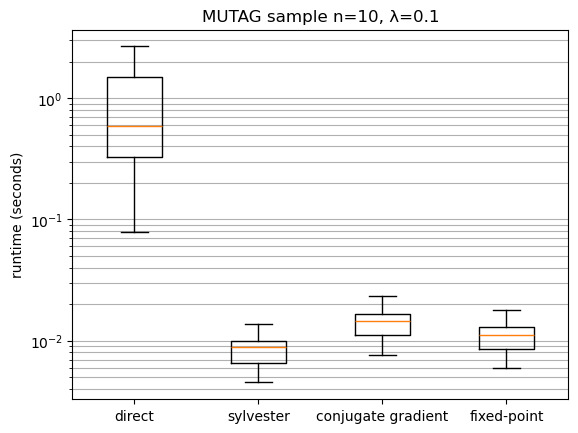

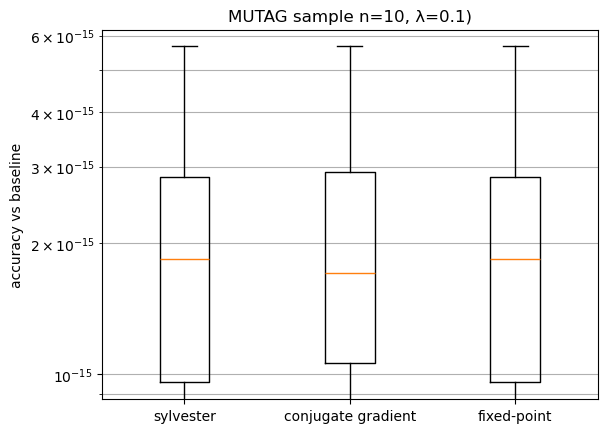

mean times:
direct:  1.2071615316199313
sylvester:  0.008601113769545919
conjugate gradient:  0.014937958380178315
fixed-point:  0.011177517930045724
mean errors vs baseline:
sylvester:  1.99902219620511e-15
conjugate gradient:  2.0207019794682702e-15
fixed-point:  1.99902219620511e-15


In [1214]:
n = int(10)
lmbd = float(0.1)
seed = int(42)
bench(sage_graphs_mutag, "MUTAG", n, lmbd, seed)

In [1215]:
ptc_mr = fetch_dataset("PTC_MR", verbose=False, as_graphs=True)
ptc_mr_graphs, y = ptc_mr.data, ptc_mr.target
print(len(ptc_mr_graphs))

sage_graphs_ptc_mr = []
for gi in ptc_mr_graphs:
    sage_graphs_ptc_mr.append(gk_to_sage_graph(gi))  

344


/opt/homebrew/Caskroom/miniforge/base/envs/sage/lib/python3.12/site-packages/grakel/graph.py:314: UserWarning: changing format from "adjacency" to "all"
  warnings.warn('changing format from "adjacency" to "all"')


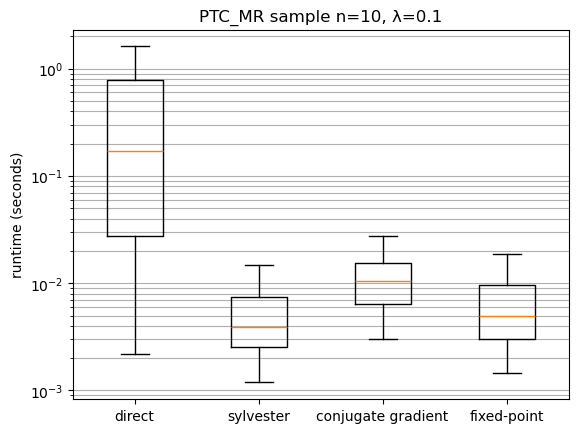

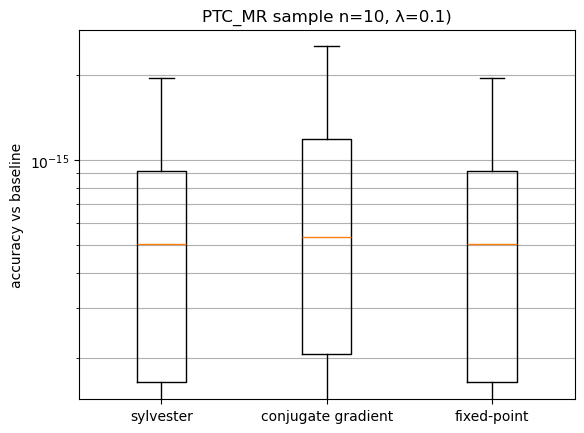

mean times:
direct:  3.0155809567298273
sylvester:  0.005352198760519968
conjugate gradient:  0.012453447080333717
fixed-point:  0.006846452958852751
mean errors vs baseline:
sylvester:  7.241012679145283e-16
conjugate gradient:  2.114353373212173e-06
fixed-point:  7.241012679145283e-16


In [1216]:
bench(sage_graphs_ptc_mr, "PTC_MR", n, lmbd, seed)

In [1241]:
proteins = fetch_dataset("PROTEINS", verbose=False, as_graphs=True)
proteins_graphs, y = proteins.data, proteins.target

sage_graphs_proteins = []
for gi in proteins_graphs:
    sage_graphs_proteins.append(gk_to_sage_graph(gi))

/opt/homebrew/Caskroom/miniforge/base/envs/sage/lib/python3.12/site-packages/grakel/graph.py:314: UserWarning: changing format from "adjacency" to "all"
  warnings.warn('changing format from "adjacency" to "all"')


In [1248]:
def bench_without_direct(dataset, name: str, n: int, lmbd: float, seed=0, sparse=True):
    bench_indexs = random.sample(range(len(dataset)), n)

    times_base, kernels_base = [], []
    times_sylv, kernels_sylv = [], []
    times_cg, kernels_cg = [], []
    times_fp, kernels_fp = [], []
    relerr_sylv, relerr_cg, relerr_fp = [], [], []

    for i in bench_indexs:
        for j in bench_indexs:
            gi = dataset[i]
            gj = dataset[j]

            ni = int(gi.num_verts())
            nj = int(gj.num_verts())

            p1 = vector(RDF, [1/ni] * ni)
            q1 = vector(RDF, [1/ni] * ni)
            p2 = vector(RDF, [1/nj] * nj)
            q2 = vector(RDF, [1/nj] * nj)

            # # direct
            # k_direct: float = None
            # t0 = time.perf_counter()
            # k_direct = rw_kernel_labeled(gi, gj, lmbd, p1, p2, q1, q2)
            # t1 = time.perf_counter()
            # times_base.append(t1 - t0)
            # kernels_base.append(float(k_direct))

            # sylvester
            t0 = time.perf_counter()
            k = rw_kernel_sylvester_equation(gi, gj, lmbd, p1, p2, q1, q2, sparse=sparse)
            t1 = time.perf_counter()
            times_sylv.append(t1 - t0)
            kernels_sylv.append(float(k))

            # conjugate gradient
            t0 = time.perf_counter()
            k = rw_kernel_conjuagte_gradient(gi, gj, lmbd, p1, p2, q1, q2, sparse=sparse)
            t1 = time.perf_counter()
            times_cg.append(t1 - t0)
            kernels_cg.append(float(k))

            # fixed point
            t0 = time.perf_counter()
            k = rw_kernel_fixed_point(gi, gj, lmbd, p1, p2, q1, q2, sparse=sparse)
            t1 = time.perf_counter()
            times_fp.append(t1 - t0)
            kernels_fp.append(float(k))

            # # optimizations vs direct
            # ks = kernels_sylv[-1]
            # kc = kernels_cg[-1]
            # kf = kernels_fp[-1]
            # relerr_sylv.append(abs(ks - k_direct)/k_direct)
            # relerr_cg.append(abs(kc - k_direct)/k_direct)
            # relerr_fp.append(abs(kf - k_direct)/k_direct)

    #time
    plt.figure()
    plt.boxplot(
        [np.array(times_base, dtype=float),
         np.array(times_sylv, dtype=float),
         np.array(times_cg, dtype=float),
         np.array(times_fp, dtype=float)],
        tick_labels=["direct", "sylvester", "conjugate gradient", "fixed-point"],
        showfliers=False
    )
    plt.yscale("log")
    plt.ylabel("runtime (seconds)")
    plt.title(f"{name} sample n={n}, λ={lmbd}")
    plt.grid(True, axis="y", which="both")
    plt.show()

    # # accuracy
    # plt.figure()
    # plt.boxplot(
    #     [np.array(relerr_sylv, dtype=float),
    #      np.array(relerr_cg, dtype=float),
    #      np.array(relerr_fp, dtype=float)],
    #     tick_labels=["sylvester", "conjugate gradient", "fixed-point"],
    #     showfliers=False
    # )
    # plt.yscale("log")
    # plt.ylabel("accuracy vs baseline")
    # plt.title(f"{name} sample n={n}, λ={lmbd}")
    # plt.grid(True, axis="y", which="both")
    # plt.show()

    #means
    print("mean times:")
    # print("direct: ", float(np.array(times_base, dtype=float).mean()))
    print("sylvester: ", float(np.array(times_sylv, dtype=float).mean()))
    print("conjugate gradient: ", float(np.array(times_cg, dtype=float).mean()))
    print("fixed-point: ", float(np.array(times_fp, dtype=float).mean()))

    # print("mean errors vs baseline:")
    # print("sylvester: ", float(np.array(relerr_sylv, dtype=float).mean()))
    # print("conjugate gradient: ", float(np.array(relerr_cg, dtype=float).mean()))
    # print("fixed-point: ", float(np.array(relerr_fp, dtype=float).mean()))

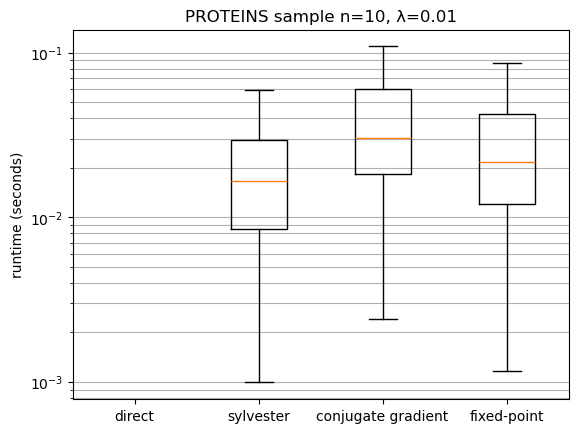

mean times:
sylvester:  0.021542930000578053
conjugate gradient:  0.04489886665978702
fixed-point:  0.031092611300264254


In [1249]:
bench_without_direct(sage_graphs_proteins, name="PROTEINS",  n=int(10), lmbd=float(0.01), seed=seed)

In [1250]:
enzymes = fetch_dataset("ENZYMES", verbose=False, as_graphs=True)
enzymes_graphs, y = enzymes.data, enzymes.target

sage_graphs_enzymes = []
for gi in enzymes_graphs:
    sage_graphs_enzymes.append(gk_to_sage_graph(gi))

/opt/homebrew/Caskroom/miniforge/base/envs/sage/lib/python3.12/site-packages/grakel/graph.py:314: UserWarning: changing format from "adjacency" to "all"
  warnings.warn('changing format from "adjacency" to "all"')


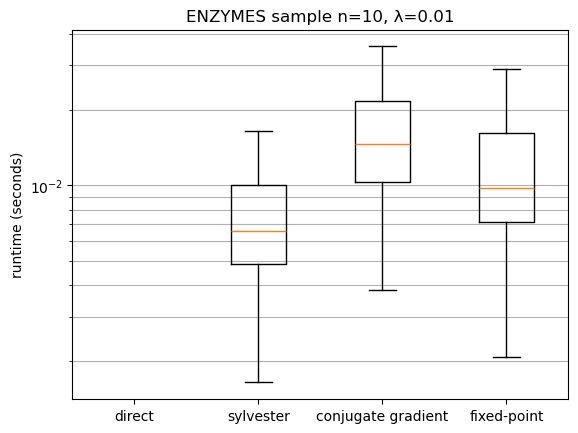

mean times:
sylvester:  0.007519900869374397
conjugate gradient:  0.017168600429577054
fixed-point:  0.011792224600358168


In [1251]:
bench_without_direct(sage_graphs_enzymes, name="ENZYMES", n=int(10), lmbd=float(0.01), seed=seed)

### Experiments

In [1235]:
from scipy.sparse.linalg import LinearOperator, bicgstab

def Wx(A1, A2, x, n1: int, n2: int, labels=None, R=RDF, sparse=True):
    if labels is None:
        labels = list(set(A1) & set(A2))
    X = matrix(R, n1, n2, list(x)).transpose()
    S = zero_matrix(R, n2, n1, sparse=sparse)
    for lab in labels:
        S += A2[lab] * X * A1[lab].transpose()
    return vector(R, S.transpose().list())

def Wtx(A1, A2, x, n1: int, n2: int, labels=None, R=RDF, sparse=True):
    if labels is None:
        labels = list(set(A1) & set(A2))
    X = matrix(R, n1, n2, list(x)).transpose()
    S = zero_matrix(R, n2, n1, sparse=sparse)
    for lab in labels:
        S += A2[lab].transpose() * X * A1[lab]
    return vector(R, S.transpose().list())

def rw_kernel_bicgstab(g1: Graph, g2: Graph, lmbd: float,
                       p1: vector, p2: vector, q1: vector, q2: vector,
                       sparse=True, eps=1e-30, atol=0.0, maxiter=500, x0=None):
    """
    solve using BiCGStab: (I - lmbd * W) x = p,  k = q^T x
    """
    n1, n2 = g1.num_verts(), g2.num_verts()
    n = n1 * n2

    p = vector(p1.tensor_product(p2).list())
    q = vector(q1.tensor_product(q2).list())

    A1 = labeled_norm_adj_mats(g1, sparse=sparse)
    A2 = labeled_norm_adj_mats(g2, sparse=sparse)

    labels = list(set(A1) & set(A2))

    def matvec(x_np):
        x = vector(RDF, x_np.tolist())
        y = x - lmbd * Wx(A1, A2, x, n1, n2, labels=labels, R=RDF, sparse=sparse)
        return np.asarray(y.list(), dtype=float)

    def rmatvec(x_np):
        x = vector(RDF, x_np.tolist())
        y = x - lmbd * Wtx(A1, A2, x, n1, n2, labels=labels, R=RDF, sparse=sparse)
        return np.asarray(y.list(), dtype=float)

    Aop = LinearOperator((n, n), matvec=matvec, rmatvec=rmatvec, dtype=float)

    b = np.asarray(p.list(), dtype=float)
    sol_np, info = bicgstab(Aop, b, rtol=eps, atol=atol, maxiter=maxiter)
    x = vector(RDF, sol_np.tolist())
    return float(q.dot_product(x))

In [1236]:
k12 = rw_kernel_bicgstab(g1, g2, lmbd, p1, p2, q1, q2)
print(k12)

k13 = rw_kernel_bicgstab(g1, g3, lmbd, p1, p3, q1, q3)
print(k13)

k23 = rw_kernel_bicgstab(g3, g2, lmbd, p3, p2, q3, q2)
print(k23)

0.004836194522770776
0.004836194522770776
0.006299757475677584


In [1239]:
def bench_with_bicgstab(dataset, name: str, n: int, lmbd: float, seed=0, sparse=True):
    bench_indexs = random.sample(range(len(dataset)), n)

    times_base, kernels_base = [], []
    times_sylv, kernels_sylv = [], []
    times_cg, kernels_cg = [], []
    times_fp, kernels_fp = [], []
    relerr_sylv, relerr_cg, relerr_fp = [], [], []

    for i in bench_indexs:
        for j in bench_indexs:
            gi = dataset[i]
            gj = dataset[j]

            ni = int(gi.num_verts())
            nj = int(gj.num_verts())

            p1 = vector(RDF, [1/ni] * ni)
            q1 = vector(RDF, [1/ni] * ni)
            p2 = vector(RDF, [1/nj] * nj)
            q2 = vector(RDF, [1/nj] * nj)

            # direct
            k_direct: float = None
            t0 = time.perf_counter()
            k_direct = rw_kernel_labeled(gi, gj, lmbd, p1, p2, q1, q2)
            t1 = time.perf_counter()
            times_base.append(t1 - t0)
            kernels_base.append(float(k_direct))

            # sylvester
            t0 = time.perf_counter()
            k = rw_kernel_sylvester_equation(gi, gj, lmbd, p1, p2, q1, q2, sparse=sparse)
            t1 = time.perf_counter()
            times_sylv.append(t1 - t0)
            kernels_sylv.append(float(k))

            # bicgstab
            t0 = time.perf_counter()
            k = rw_kernel_bicgstab(gi, gj, lmbd, p1, p2, q1, q2, sparse=sparse)
            t1 = time.perf_counter()
            times_cg.append(t1 - t0)
            kernels_cg.append(float(k))

            # fixed point
            t0 = time.perf_counter()
            k = rw_kernel_fixed_point(gi, gj, lmbd, p1, p2, q1, q2, sparse=sparse)
            t1 = time.perf_counter()
            times_fp.append(t1 - t0)
            kernels_fp.append(float(k))

            # optimizations vs direct
            ks = kernels_sylv[-1]
            kc = kernels_cg[-1]
            kf = kernels_fp[-1]
            relerr_sylv.append(abs(ks - k_direct)/k_direct)
            relerr_cg.append(abs(kc - k_direct)/k_direct)
            relerr_fp.append(abs(kf - k_direct)/k_direct)

    #time
    plt.figure()
    plt.boxplot(
        [np.array(times_base, dtype=float),
         np.array(times_sylv, dtype=float),
         np.array(times_cg, dtype=float),
         np.array(times_fp, dtype=float)],
        tick_labels=["direct", "sylvester", "bicgstab", "fixed-point"],
        showfliers=False
    )
    plt.yscale("log")
    plt.ylabel("runtime (seconds)")
    plt.title(f"{name} sample n={n}, λ={lmbd}")
    plt.grid(True, axis="y", which="both")
    plt.show()

    # accuracy
    plt.figure()
    plt.boxplot(
        [np.array(relerr_sylv, dtype=float),
         np.array(relerr_cg, dtype=float),
         np.array(relerr_fp, dtype=float)],
        tick_labels=["sylvester", "bicgstab", "fixed-point"],
        showfliers=False
    )
    plt.yscale("log")
    plt.ylabel("accuracy vs baseline")
    plt.title(f"{name} sample n={n}, λ={lmbd}")
    plt.grid(True, axis="y", which="both")
    plt.show()

    #means
    print("mean times:")
    print("direct: ", float(np.array(times_base, dtype=float).mean()))
    print("sylvester: ", float(np.array(times_sylv, dtype=float).mean()))
    print("bicgstab: ", float(np.array(times_cg, dtype=float).mean()))
    print("fixed-point: ", float(np.array(times_fp, dtype=float).mean()))

    print("mean errors vs baseline:")
    print("sylvester: ", float(np.array(relerr_sylv, dtype=float).mean()))
    print("bicgstab: ", float(np.array(relerr_cg, dtype=float).mean()))
    print("fixed-point: ", float(np.array(relerr_fp, dtype=float).mean()))

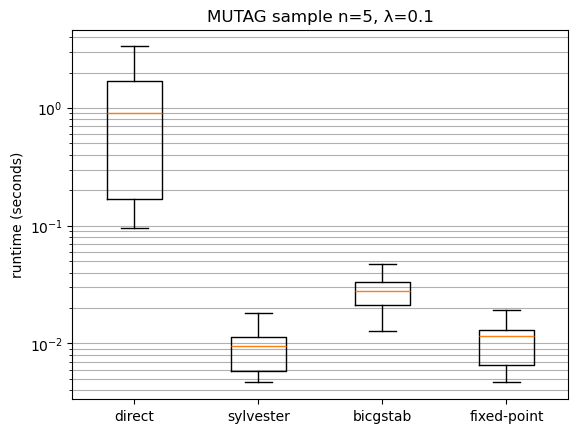

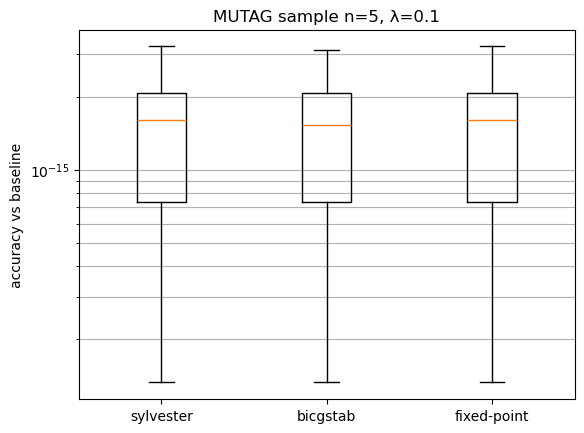

mean times:
direct:  1.2938936133193784
sylvester:  0.00915596011967864
bicgstab:  0.027972203358076514
fixed-point:  0.010767233281512745
mean errors vs baseline:
sylvester:  1.655804627446465e-15
bicgstab:  1.6148458015512778e-15
fixed-point:  1.655804627446465e-15


In [ ]:
bench_with_bicgstab(sage_graphs_mutag, name="MUTAG", n=int(5), lmbd=lmbd, seed=seed)